# Защита персональных данных клиентов

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуем корректность его работы.

Защитим данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [4]:
#Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st

#хитмэп корреляции
import os
import seaborn as sns

#операции с выборкой
from sklearn.model_selection import train_test_split

#сохранение модели
import joblib 
from joblib import dump

#классификация
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

#регрессия
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor #создание конст модели: среднее, медиана и др

#преобразователь масштаба методом стандартизации
from sklearn.preprocessing import StandardScaler

#метрики
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score #кросс-валидация
from sklearn.metrics import make_scorer #для написания ручной оценки

#подбор параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#построение ROC-кривой
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve 
from sklearn import metrics
from sklearn.metrics import roc_auc_score
#построение графиков
import seaborn as sns

#раздел upsampling
from sklearn.utils import shuffle

In [5]:
#Уберем предупреждения и ограничения:

#D:\installed\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.if _joblib.__version__ >= LooseVersion('0.12'):
import warnings
warnings.filterwarnings('ignore')

#SettingWithCopy 
#при записи изменённых признаков в исходный датафрейм (особенности поведения sklearn и pandas)
pd.options.mode.chained_assignment = None

#отключим предупреждением библиотеки sklearn при обучении логистической регрессии, 
#укажем аргумент solver='liblinear' (англ. solver «алгоритм решения»; library linear, «библиотека линейных алгоритмов»)

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [6]:
#загрузим датасет
try:
    data = pd.read_csv('/datasets/insurance.csv')
   
except FileNotFoundError:
    data = pd.read_csv('gold_recovery_full_new.csv')
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


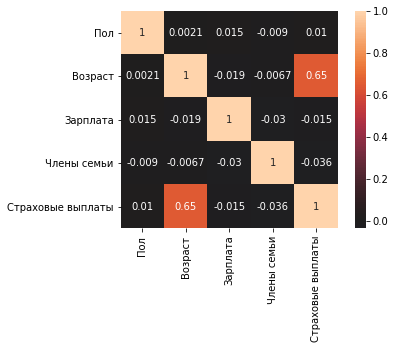

In [7]:
#проверим корреляцию признаков
for df in [data]:
    #Numeric columns of the dataset
    numeric_col = ['Пол','Возраст','Зарплата', 'Члены семьи', 'Страховые выплаты']
    #Correlation Matrix formation
    corr_matrix = df.loc[:,numeric_col].corr()
    #Using heatmap to visualize the correlation matrix
    plt.show()
    sns.heatmap(df.corr(), annot=True, fmt='.2g', square=True, center= 0)

### Вывод
    Загрузили датасет
    Выявили среднюю связь по шкале Чеддока между признаками: Страховые выплаты и Возраст 
    Все остальные связи относятся к очень слабым

## Умножение матриц

Формулы линейной регрессии

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$ 

$$
w_1=({{(XP)}^TXP)}^{-1}{(XP)}^Ty=\;\\\\={(P^TX^TXP)}^{-1}P^TX^Ty=\;\\\\=P^{-1}{(X^TX)}^{-1}{(P^T)}^{-1}P^TX^Ty=>\;\;\;\\\;\;\;\;\;\;\;\\\#{(P^T)}^{-1}P^T=E\;(1)\\\\=>P^{-1}{(X^TX)}^{-1}X^Ty=>\;\;\;\\\;\;\;\;\;\;\;\\\#{(X^TX)}^{-1}X^Ty=w\;(2)\\\\=>P^{-1}w.\\\\a_1=X_1w_1=(XP)(P^{-1}w)=\\\\=XPP^{-1}w=Xw\\\\a_1=Xw=a\\\\a_1\equiv a
$$

In [5]:
#подготовим признаки
features = data.drop('Страховые выплаты', axis=1)
target = data['Страховые выплаты']

features_orig = data.drop('Страховые выплаты', axis=1) # для 4 пункта проекта
target_orig = data['Страховые выплаты']


print(features.shape)

(5000, 4)


In [6]:
#сгенерируем рандомом матрицу и сохраним идин из вариантов ниже
matrix = np.random.normal(10, size = (4, 4))
matrix

array([[ 9.95473882,  9.44963673,  8.92906606,  8.90035789],
       [11.02295881,  9.11662339,  7.97219795, 11.86367907],
       [ 8.93971179, 10.59866041,  9.18976025, 10.63715118],
       [10.38483232, 10.34997284,  9.01551126,  8.22119102]])

In [6]:
matrix = np.array([[2, 7, 0, 0],
       [8, 2, 4, 5],
       [8, 8, 9, 3],
       [1, 9, 0, 1]])

In [7]:
#создадим обратную матрицу и проверим
matrix_inv = np.linalg.inv(matrix)
matrix_inv

array([[ 0.46348733,  0.09388972, -0.04172876, -0.3442623 ],
       [ 0.01043219, -0.02682563,  0.0119225 ,  0.09836066],
       [-0.23546945, -0.10879285,  0.15946349,  0.06557377],
       [-0.55737705,  0.14754098, -0.06557377,  0.45901639]])

In [8]:
#проверим обратимость матрицы, получим Е (единичную матрицу)
print('matrix @ matrix_inv:',)
print(matrix @ matrix_inv)

np.around((matrix @ matrix_inv), decimals = 2)

matrix @ matrix_inv:
[[ 1.00000000e+00 -6.93889390e-17  3.64291930e-17  1.11022302e-16]
 [ 1.11022302e-16  1.00000000e+00  1.38777878e-17  6.10622664e-16]
 [ 7.77156117e-16 -2.77555756e-17  1.00000000e+00  4.99600361e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


array([[ 1., -0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0., -0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [9]:
#умножим признаки на обратимую матрицу
features_multiplied_matrixinv = np.array(features) @ matrix
features_multiplied_matrixinv

array([[397131., 396898., 446564., 149006.],
       [304369., 304101., 342184., 114231.],
       [168232., 168058., 189116.,  63145.],
       ...,
       [271362., 271258., 305180., 101802.],
       [261781., 261678., 294388.,  98213.],
       [325027., 324872., 365512., 121941.]])

In [10]:
#измерим и сравним R2 при обучении:
##features
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = (np.linalg.inv(X.T @ X)) @ X.T @ y
        self.w = w[1:]
        self.w0 = w[0]
        print('w', w)
        print('self.w', self.w)
        print('self.w0', self.w0)

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0
    
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
r2_features = r2_score(target, predictions)
print(r2_features)

w [-9.38235504e-01  7.92580543e-03  3.57083050e-02 -1.70080492e-07
 -1.35676623e-02]
self.w [ 7.92580543e-03  3.57083050e-02 -1.70080492e-07 -1.35676623e-02]
self.w0 -0.9382355041524771
0.42494550286668


In [11]:
##features_multiplied_matrixinv
model = LinearRegression()
model.fit(features_multiplied_matrixinv, target)
predictions = model.predict(features_multiplied_matrixinv)
r2_features_multiplied_matrixinv = r2_score(target, predictions)
print(r2_features_multiplied_matrixinv)

w [-0.93823884  0.01169705 -0.00220974 -0.00664083 -0.00537706]
self.w [ 0.01169705 -0.00220974 -0.00664083 -0.00537706]
self.w0 -0.938238836450605
0.4249455028587986


In [12]:
print('разница:', r2_features - r2_features_multiplied_matrixinv)

разница: 7.881362229511524e-12


**Ответ:** Не изменится
Признаки умножили на обратимую матрицу. Качество линейной регресии практически не изменилось, уменьшилось на величину 7.881362229511524e-12

**Обоснование:** 
Параметры линейной регрессии: w, self.w, self.w0 
в исходной задаче и в преобразованной задаче
связаны через y = train_target 
в формуле  w = (np.linalg.inv(X.T @ X)) @ X.T @ y
также видно что параметр self.w0 величина сдвига предсказания (англ. bias) - практически одинаков.

## Алгоритм преобразования
    Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию
    
    Предложим алгоритм преобразования данных для решения задачи. 
    Обоснуем, почему качество линейной регрессии не поменяется.    

**Запишем Алгоритм преобразования и обратного преобразования**

    features_encrypted = features @ matrix_B - number
    features_original  = (features_encrypted + number) @ matrix_B_inv 
    
    matrix_B - произвольная обратимая матрица нужной размерности (количество стообцов features = количеству и столбцов и строк matrix_B)
    number   - произвольное число

*после преобразований округлим features_original до нужного количества знаков после запятой как в исходной мтрице признаков
np.around(features_original, decimals = 1)
чтобы убрать погрешности связанные с ограниченной разрядностью вычислений

*для генерации матрицы B можно применять np.random.randint(10, size=(features.shape[1], features.shape[1])), как пример

**Обоснование
При выполнении комбинации простейших действий с матрицей, не приводящих к превращению элементов матрицы в ноль, ее возможно восстановить, зная лишь комбинацию действий и чисел

In [13]:
features = np.array([[1.3, 2.0, 3.0],
                     [4.0, 5.0, 6.0],
                     [7.0, 8.0, 9.0]])

matrix_B = np.array([[1.0, 3.0, 5.0],
                     [7.0, 9.0, 1.0],
                     [3.0, 5.0, 9.0]])

matrix_B_inv =  np.linalg.inv(matrix_B)

number = 7

In [14]:
features_encrypted = features @ matrix_B - number
features_encrypted

array([[ 17.3,  29.9,  28.5],
       [ 50. ,  80. ,  72. ],
       [ 83. , 131. , 117. ]])

In [15]:
features_original  = (features_encrypted + number) @ matrix_B_inv 
np.around(features_original, decimals = 1)

array([[1.3, 2. , 3. ],
       [4. , 5. , 6. ],
       [7. , 8. , 9. ]])

## Проверка алгоритма

In [16]:
model = LinearRegression()

model.fit(features_orig, target_orig)
predictions = model.predict(features_orig)

r2_features = r2_score(target_orig, predictions)
print(r2_features)

w [-9.38235504e-01  7.92580543e-03  3.57083050e-02 -1.70080492e-07
 -1.35676623e-02]
self.w [ 7.92580543e-03  3.57083050e-02 -1.70080492e-07 -1.35676623e-02]
self.w0 -0.9382355041524771
0.42494550286668


In [17]:
matrix_B = np.random.randint(777, size=(features_orig.shape[1], features_orig.shape[1]))
number = 55
features_encrypted = features_orig @ matrix_B - number



model = LinearRegression()

model.fit(features_encrypted, target_orig)
predictions = model.predict(features_encrypted)

r2_features_encrypted = r2_score(target_orig, predictions)
print(r2_features_encrypted)

w [-9.37313904e-01  1.26317986e-04  4.36312870e-05 -1.08708068e-04
 -4.44718387e-05]
self.w [ 1.26317986e-04  4.36312870e-05 -1.08708068e-04 -4.44718387e-05]
self.w0 -0.9373139037889865
0.42494550286637944


In [18]:
print(r2_features-r2_features_encrypted)

3.005373727660299e-13


<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Качество предскзазания действительно не изменяется, результат достигнут!
    
Еще могу порекомендовать вот такой материал:
    
https://habr.com/ru/post/479398/
    
</div>

**Вывод:**

    Получили простейший алгорит преобразования данных для защиты информации.
    Возможно вернуть исходные данные при наличии информации о последовательности комбинаций и используемых чисел.
    Разница между качеством r2 на исходной и зашифрованной матрице составляет 8.948397578478762e-14.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные загружены
- [ ]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [ ]  Указан правильный вариант ответа
    - [ ]  Вариант обоснован
- [ ]  Выполнен шаг 3: предложен алгоритм преобразования
    - [ ]  Алгоритм описан
    - [ ]  Алгоритм обоснован
- [ ]  Выполнен шаг 4: алгоритм проверен
    - [ ]  Алгоритм реализован
    - [ ]  Проведено сравнение качества моделей до и после преобразования